This notebook briefly outlines how to get lightcurve data for particular events from different microlensing alert webpages.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import requests
import pandas as pd
from io import BytesIO
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numexpr as ne

First, we just show how to dump everything into a pandas dataframe and plot the downloaded data.

# MOA

http://www.massey.ac.nz/~iabond/moa/alert2021/display.php?id=gb4-R-5-47895


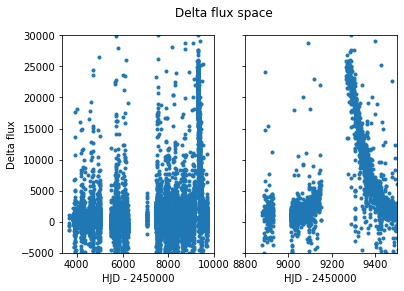

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


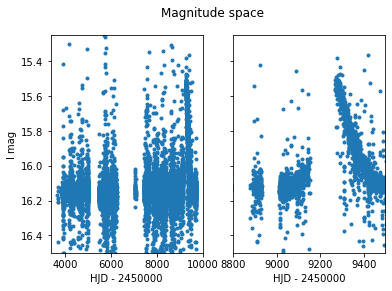

In [15]:
year = "2022"
event = "gb8-R-3-40286"

year = "2021"
event = "gb4-R-5-47895"

# Scrape alert website for magnitude and flux offsets.
url = "http://www.massey.ac.nz/~iabond/moa/alert" + year + "/display.php?id=" + event
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

# Get the magnitude and flux offsets.
foo = soup.find('b').next_sibling
moff = foo.split('=')[1].split('-')[0].strip(' ')
bah = soup.find('sub').next_sibling
foff = bah.split('+')[1].split(')')[0].strip(' ')

# Now convert these into floats
m = ne.evaluate(moff)
f = ne.evaluate(foff)

# Now scrape the .dat file into a pandas dataframe.
url = "https://www.massey.ac.nz/~iabond/moa/alert" + year + "/fetchtxt.php?path=moa/ephot/phot-" + event + ".dat"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), 
                 delim_whitespace=True, skiprows=11, skipfooter=1, header=None, engine='python', 
                 names=['hjd', 'delta_flux', 'flux', 'foo1', 'foo2', 'foo3', 'foo4', 'foo5'])

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(df['hjd'] - 2450000, df['delta_flux'], '.')
ax[1].plot(df['hjd'] - 2450000, df['delta_flux'], '.')
ax[1].set_xlim(8800, 9500)
ax[1].set_ylim(-5000, 30000)
ax[0].set_ylabel('Delta flux')
ax[0].set_xlabel('HJD - 2450000')
ax[1].set_xlabel('HJD - 2450000')
plt.suptitle('Delta flux space')
plt.show()

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(df['hjd'] - 2450000, m - 2.5*np.log10(df['delta_flux'] + f), '.')
ax[1].plot(df['hjd'] - 2450000, m - 2.5*np.log10(df['delta_flux'] + f), '.')
ax[1].set_xlim(8800, 9500)
ax[1].set_ylim(15.25, 16.5)
ax[0].set_ylabel('I mag')
ax[0].set_xlabel('HJD - 2450000')
ax[1].set_xlabel('HJD - 2450000')
ax[0].invert_yaxis()
plt.suptitle('Magnitude space')
plt.show()

In [40]:
# Why is there missing data???
url = "http://www.massey.ac.nz/~iabond/moa/alert2022/fetchtxt.php?path=moa/ephot/phot-gb8-R-3-40286.dat"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), delim_whitespace=True, skiprows=11, skipfooter=1, header=None, engine='python')

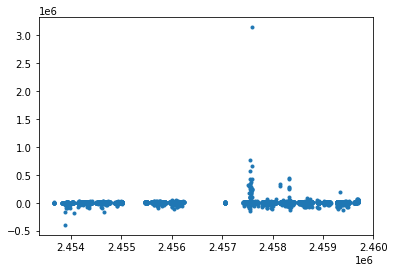

In [48]:
import matplotlib.pyplot as plt
plt.plot(df.iloc[:,0], df.iloc[:,1], '.')

# OGLE

In [1]:
import ftplib
ftp = ftplib.FTP("ftp.astrouw.edu.pl")
ftp.login()

'230-Welcome to Warsaw University Observatory FTP service\n230-\n230 Login successful.'

In [2]:
ftp.cwd("ogle/ogle4/ews/2019")

'250 Directory successfully changed.'

In [3]:
ftp.dir()

drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0001
-rw-rw-r--    1 ftp      ftp        844512 Nov 04  2019 blg-0001.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0002
-rw-rw-r--    1 ftp      ftp        741961 Nov 04  2019 blg-0002.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0003
-rw-rw-r--    1 ftp      ftp        800806 Nov 04  2019 blg-0003.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0004
-rw-rw-r--    1 ftp      ftp        776398 Nov 04  2019 blg-0004.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0005
-rw-rw-r--    1 ftp      ftp        803128 Nov 04  2019 blg-0005.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0006
-rw-rw-r--    1 ftp      ftp        789638 Nov 04  2019 blg-0006.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0007
-rw-rw-r--    1 ftp      ftp        685616 Nov 04  2019 blg-0007.tar.gz
drwxrwxr-x    2 ftp      ftp          409

-rw-rw-r--    1 ftp      ftp        722106 Nov 04  2019 blg-0213.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0214
-rw-rw-r--    1 ftp      ftp        659989 Oct 10  2019 blg-0214.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0215
-rw-rw-r--    1 ftp      ftp        648454 Oct 10  2019 blg-0215.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0216
-rw-rw-r--    1 ftp      ftp        663951 Oct 10  2019 blg-0216.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0217
-rw-rw-r--    1 ftp      ftp        466675 Oct 10  2019 blg-0217.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0218
-rw-rw-r--    1 ftp      ftp        589249 Oct 10  2019 blg-0218.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0219
-rw-rw-r--    1 ftp      ftp        660430 Oct 10  2019 blg-0219.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0220
-rw-rw-r--    1 ftp      ftp        75123

-rw-rw-r--    1 ftp      ftp        820667 Nov 03  2019 blg-0537.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0538
-rw-rw-r--    1 ftp      ftp        689321 Nov 03  2019 blg-0538.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 09  2019 blg-0539
-rw-rw-r--    1 ftp      ftp        577301 Oct 09  2019 blg-0539.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0540
-rw-rw-r--    1 ftp      ftp        802502 Nov 03  2019 blg-0540.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0541
-rw-rw-r--    1 ftp      ftp        772431 Nov 03  2019 blg-0541.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 06  2019 blg-0542
-rw-rw-r--    1 ftp      ftp        613650 Oct 06  2019 blg-0542.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 09  2019 blg-0543
-rw-rw-r--    1 ftp      ftp        641251 Oct 09  2019 blg-0543.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 06  2019 blg-0544
-rw-rw-r--    1 ftp      ftp        53624

drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-1022
-rw-rw-r--    1 ftp      ftp        486677 Nov 03  2019 blg-1022.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-1023
-rw-rw-r--    1 ftp      ftp        678303 Nov 03  2019 blg-1023.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 06  2019 blg-1024
-rw-rw-r--    1 ftp      ftp        591723 Oct 06  2019 blg-1024.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-1025
-rw-rw-r--    1 ftp      ftp        714242 Nov 03  2019 blg-1025.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Sep 27  2019 blg-1026
-rw-rw-r--    1 ftp      ftp        692748 Sep 27  2019 blg-1026.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 09  2019 blg-1027
-rw-rw-r--    1 ftp      ftp        655379 Oct 09  2019 blg-1027.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 09  2019 blg-1028
-rw-rw-r--    1 ftp      ftp        630422 Oct 09  2019 blg-1028.tar.gz
drwxrwxr-x    2 ftp      ftp          409

In [4]:
from io import BytesIO
import ftplib
import pandas as pd
ftp = ftplib.FTP("ftp.astrouw.edu.pl")
ftp.login()
ftp.cwd("ogle/ogle4/ews/2019/blg-0002")

# Figure out how to write to array instead of file.
# Or maybe directly to SQL database?
# https://stackoverflow.com/questions/18772703/read-a-file-in-buffer-from-ftp-python
flo = BytesIO()
# ftp.retrbinary('RETR phot.dat', 
#                open('blg-0002.phot.dat', 'wb').write)
ftp.retrbinary('RETR phot.dat', flo.write)
flo.seek(0)
x = pd.read_fwf(flo, header=0, names=['HJD', 'mag', 'mag_err', 'see', 'sky'])

In [7]:
ftp.cwd("../blg-0001")

'250 Directory successfully changed.'

In [8]:
ftp.cwd('../')

'250 Directory successfully changed.'

In [9]:
ftp.dir()

drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0001
-rw-rw-r--    1 ftp      ftp        844512 Nov 04  2019 blg-0001.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0002
-rw-rw-r--    1 ftp      ftp        741961 Nov 04  2019 blg-0002.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0003
-rw-rw-r--    1 ftp      ftp        800806 Nov 04  2019 blg-0003.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0004
-rw-rw-r--    1 ftp      ftp        776398 Nov 04  2019 blg-0004.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0005
-rw-rw-r--    1 ftp      ftp        803128 Nov 04  2019 blg-0005.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0006
-rw-rw-r--    1 ftp      ftp        789638 Nov 04  2019 blg-0006.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0007
-rw-rw-r--    1 ftp      ftp        685616 Nov 04  2019 blg-0007.tar.gz
drwxrwxr-x    2 ftp      ftp          409

-rw-rw-r--    1 ftp      ftp        722106 Nov 04  2019 blg-0213.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0214
-rw-rw-r--    1 ftp      ftp        659989 Oct 10  2019 blg-0214.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0215
-rw-rw-r--    1 ftp      ftp        648454 Oct 10  2019 blg-0215.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0216
-rw-rw-r--    1 ftp      ftp        663951 Oct 10  2019 blg-0216.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0217
-rw-rw-r--    1 ftp      ftp        466675 Oct 10  2019 blg-0217.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0218
-rw-rw-r--    1 ftp      ftp        589249 Oct 10  2019 blg-0218.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0219
-rw-rw-r--    1 ftp      ftp        660430 Oct 10  2019 blg-0219.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 04  2019 blg-0220
-rw-rw-r--    1 ftp      ftp        75123

drwxrwxr-x    2 ftp      ftp          4096 Oct 10  2019 blg-0497
-rw-rw-r--    1 ftp      ftp        620026 Oct 10  2019 blg-0497.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0498
-rw-rw-r--    1 ftp      ftp        613399 Nov 03  2019 blg-0498.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0499
-rw-rw-r--    1 ftp      ftp        591790 Nov 03  2019 blg-0499.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Aug 02  2019 blg-0500
-rw-rw-r--    1 ftp      ftp        438617 Aug 02  2019 blg-0500.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0501
-rw-rw-r--    1 ftp      ftp        721242 Nov 03  2019 blg-0501.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0502
-rw-rw-r--    1 ftp      ftp        825349 Nov 03  2019 blg-0502.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0503
-rw-rw-r--    1 ftp      ftp        675867 Nov 03  2019 blg-0503.tar.gz
drwxrwxr-x    2 ftp      ftp          409

drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0953
-rw-rw-r--    1 ftp      ftp        640136 Nov 03  2019 blg-0953.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0954
-rw-rw-r--    1 ftp      ftp        800507 Nov 03  2019 blg-0954.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0955
-rw-rw-r--    1 ftp      ftp        845950 Nov 03  2019 blg-0955.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0956
-rw-rw-r--    1 ftp      ftp        701004 Nov 03  2019 blg-0956.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0957
-rw-rw-r--    1 ftp      ftp        629245 Nov 03  2019 blg-0957.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0958
-rw-rw-r--    1 ftp      ftp        827590 Nov 03  2019 blg-0958.tar.gz
drwxrwxr-x    2 ftp      ftp          4096 Nov 03  2019 blg-0959
-rw-rw-r--    1 ftp      ftp        827315 Nov 03  2019 blg-0959.tar.gz
drwxrwxr-x    2 ftp      ftp          409

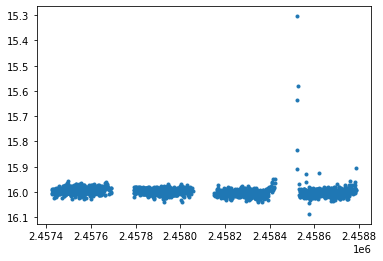

In [8]:
import matplotlib.pyplot as plt
plt.plot(x['HJD'], x['mag'], '.')
plt.gca().invert_yaxis()

# KMTNet

In [101]:
# How you can write out data from the KMTNet file into a pandas dataframe.
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/data/KB220002/pysis/KMTA01_I.pysis"
bytes_data = requests.get(url).content
df = pd.read_csv(BytesIO(bytes_data), 
                 delim_whitespace=True, skiprows=1, header=None, 
                 names=['HJD', 'Delta_flux', 'flux_err', 'mag', 'mag_err', 'fwhm', 'sky', 'secz'])

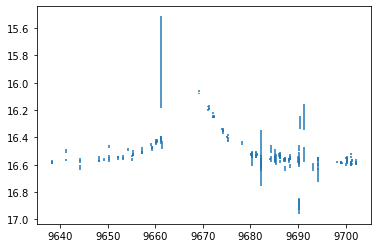

In [102]:
# Some plotting just to see.
import matplotlib.pyplot as plt
plt.errorbar(df['HJD'], df['mag'], yerr=df['mag_err'], ls='none')
#plt.ylim(15.7, 16.25)
plt.gca().invert_yaxis()

In [103]:
# For KMTNet, get data from all the telescopes. But they're different for each page.
# So here is how you can get all the names of the files.
# (Do we really want to do this?)
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0001"
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

links = soup.find_all('a', href=True)

# What is the difference between text and get_text?
print(links[3].get_text(separator=',').split(',')[:-2])

# Compare the output of a different alert:
url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0002"
print(url)
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")

links = soup.find_all('a', href=True)

# What is the difference between text and get_text?
print(links[3].get_text(separator=',').split(',')[:-2])

https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0001
['KMTA04_I.pysis', 'KMTC01_I.pysis', 'KMTC04_I.pysis', 'KMTC04_V.pysis', 'KMTS01_I.pysis', 'KMTS01_V.pysis', 'KMTS04_I.pysis']
https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-0002
['KMTA01_I.pysis', 'KMTA01_V.pysis', 'KMTA41_I.pysis', 'KMTA41_V.pysis', 'KMTC01_I.pysis', 'KMTC01_V.pysis', 'KMTC41_I.pysis', 'KMTC41_V.pysis', 'KMTS01_I.pysis', 'KMTS01_V.pysis', 'KMTS41_I.pysis', 'KMTS41_V.pysis']


Next, we'll put things into databases. Let's use SQLAlchemy.

In [124]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///foo.db')

import time 

counter = 0

t0 = time.time()

for nn in np.arange(start=1, stop=11, step=1):
    # For KMTNet, get data from all the telescopes?
    url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/view.php?event=KMT-2022-BLG-" + str(nn).zfill(4)
#    print(url)
    response = urlopen(url)
    html = response.read()
    response.close()
    soup = BeautifulSoup(html,"html.parser")
    
    links = soup.find_all('a', href=True)

    # What is the difference between text and get_text?
    pysis_names = links[3].get_text(separator=',').split(',')[:-2]
    
    for pysis_name in pysis_names:
        url = "https://kmtnet.kasi.re.kr/~ulens/event/2022/data/KB22" + str(nn).zfill(4) + "/pysis/" + pysis_name
#        print(url)
        bytes_data = requests.get(url).content
        try:
            df = pd.read_csv(BytesIO(bytes_data), 
                             delim_whitespace=True, skiprows=1, header=None, 
                             names=['HJD', 'Delta_flux', 'flux_err', 'mag', 'mag_err', 'fwhm', 'sky', 'secz'])

            # Only keep HJD, mag, mag_err.
            df.drop(columns=['Delta_flux', 'flux_err', 'fwhm', 'sky', 'secz'])
            df['alert_system'] = 'KMTNet'
            df['alert_name'] = 'KB22' + str(nn).zfill(4) 
            df['lightcurve'] = pysis_name
            df.to_sql(con=engine, schema=None, name="kmtnet", if_exists="append", index=False)
            counter += 1
        except:
            print('This doesn\'t exist, skipping.'.format(nn))
            continue
t1 = time.time()

print('Time to write table: {0:.0f} sec for {1} files ({2} alerts)'.format(t1 - t0, counter, nn))

Time to write table: 112 sec for 109 files (10 alerts)


In [125]:
conn = engine.connect()

In [126]:
x = engine.execute("SELECT HJD FROM kmtnet").fetchall()
print(len(x))

22834


In [127]:
from sqlalchemy.sql import select
from sqlalchemy import text
s = text('SELECT * FROM kmtnet')
result = conn.execute(s)

In [128]:
result.fetchall()

[(9641.22538, -5177.7646, 454.4557, 15.9393, 0.0074, 9.2, 1100, 1.59, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9644.20631, 7092.6119, 609.4399, 16.1599, 0.0122, 12.43, 1041, 1.72, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9644.26027, -5279.4189, 392.8658, 15.9376, 0.0064, 9.28, 932, 1.27, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9648.23209, -7215.8071, 350.0599, 15.9066, 0.0055, 6.62, 1042, 1.38, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9649.18022, -7096.6154, 350.9347, 15.9085, 0.0056, 9.15, 1135, 1.9, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9650.17749, -7945.1495, 397.7813, 15.8952, 0.0062, 9.96, 971, 1.9, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9650.23155, -7454.0244, 350.5003, 15.9029, 0.0055, 8.58, 1009, 1.35, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9652.1816, -8293.3857, 371.8765, 15.8897, 0.0058, 8.03, 891, 1.76, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),
 (9652.23741, -8061.2088, 289.1625, 15.8934, 0.0045, 4.36, 832, 1.28, 'KMTNet', 'KB220001', 'KMTA04_I.pysis'),


In [14]:
import sqlalchemy
sqlalchemy.__version__

'1.4.32'

In [123]:
# s = text('DROP TABLE kmtnet')
# result = conn.execute(s)